In [75]:
import igraph
import community
import numpy as np
from math import *
import networkx as nx
import matplotlib.pyplot as plt
from igraph import *
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import linregress
from scipy.stats import norm
from scipy.stats import chi2_contingency
from matplotlib.patches import Rectangle

In [2]:
def partitionAnal(dictPart, lHouse):
    lFraction = []
    lMax = []
    lValues = list(dictPart.values())
    dUse = {}
    for val in lValues:
        dUse[val] = []
    for node, val in dictPart.items():
        dUse[val].append(node)
    for part, lNodes in dUse.items():
        denom = 0
        n = len(lNodes)
        if n > 1:
            for node in lNodes:
                if lHouse[node, -1] == 1:
                    denom += 1
            lFraction.append((n,denom/n))
            lMax.append((denom/n, n))
    maxEl = max(lMax)
    return [lFraction, maxEl, dUse]

In [3]:
path = "/home/pierre/Documents/CourseOxford/MiniProjectData/social_0/social/adjacency_matrices/"
lData = []
def importMat(i):
    mat = pd.read_csv(path + "adjmat" + str(i) + ".csv", header=None)
    return mat

for i in range(43):
    lData.append(importMat(i+1).values)

dfHouse = pd.read_csv("/home/pierre/Documents/CourseOxford/MiniProjectData/social_0/social/householdcharacteristics.csv")
for i in range(dfHouse.shape[0]):
    if dfHouse.iloc[i]["ownrent"] == "LEASED":
        print(dfHouse.iloc[i])
        dfHouse.iloc[i]["ownrent"] = "RENTED"
matHouse = dfHouse.values
lHouseVill = []
lHouseVillDf = []
c = 0
for i in range(43):
    a = lData[i].shape[0]
    lHouseVill.append(matHouse[c:c + a])
    c += a

village                        3
HHnum_in_village             143
hohreligion             HINDUISM
castesubcaste                NaN
rooftype1                      0
rooftype2                      1
rooftype3                      0
rooftype4                      0
rooftype5                      0
room_no                        4
bed_no                         3
electricity         Yes, Private
latrine                     None
ownrent                   LEASED
leader                         0
adopt                          0
Name: 518, dtype: object
village                        3
HHnum_in_village             292
hohreligion             HINDUISM
castesubcaste                NaN
rooftype1                      0
rooftype2                      0
rooftype3                      0
rooftype4                      1
rooftype5                      0
room_no                        2
bed_no                         0
electricity         Yes, Private
latrine                     None
ownrent           

/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


village                       16
HHnum_in_village             138
hohreligion                ISLAM
castesubcaste           MINORITY
rooftype1                      0
rooftype2                      0
rooftype3                      0
rooftype4                      1
rooftype5                      0
room_no                        2
bed_no                         1
electricity         Yes, Private
latrine                     None
ownrent                   LEASED
leader                         0
adopt                          0
Name: 3233, dtype: object
village                          16
HHnum_in_village                139
hohreligion                   ISLAM
castesubcaste              MINORITY
rooftype1                         0
rooftype2                         1
rooftype3                         0
rooftype4                         0
rooftype5                         0
room_no                           2
bed_no                            1
electricity         Yes, Government
latrine       

In [4]:
lResult = []
lMean = []
lMax = []
ldUse = []
for i in range(43):
    mat = lData[i]
    G = nx.from_numpy_matrix(mat)
    dictCom = community.best_partition(G)
    [lFraction, maxEl, dUse] = partitionAnal(dictCom, lHouseVill[i])
    ldUse.append(dUse)
    lResult.append(lFraction)
    maxEl = tuple((list(maxEl)) + [i])
    lMax.append(maxEl)
lMaxSorted = sorted(lMax, key=lambda k: k[0])
print(lResult)

[[(34, 0.2647058823529412), (44, 0.20454545454545456), (15, 0.2), (28, 0.21428571428571427), (15, 0.3333333333333333), (22, 0.2727272727272727), (17, 0.23529411764705882)], [(56, 0.125), (19, 0.15789473684210525), (34, 0.20588235294117646), (69, 0.13043478260869565)], [(50, 0.06), (49, 0.30612244897959184), (14, 0.07142857142857142), (37, 0.02702702702702703), (16, 0.0), (40, 0.3), (66, 0.09090909090909091)], [(25, 0.0), (7, 0.0), (36, 0.0), (36, 0.0), (53, 0.2641509433962264), (26, 0.038461538461538464), (18, 0.05555555555555555), (21, 0.047619047619047616)], [(30, 0.3333333333333333), (16, 0.25), (14, 0.21428571428571427), (19, 0.21052631578947367), (9, 0.1111111111111111), (19, 0.15789473684210525)], [(23, 0.08695652173913043), (53, 0.32075471698113206), (41, 0.14634146341463414), (14, 0.35714285714285715), (70, 0.1)], [(21, 0.047619047619047616), (38, 0.21052631578947367), (27, 0.2222222222222222), (17, 0.17647058823529413), (24, 0.4166666666666667), (21, 0.42857142857142855), (18,

Chi-Square test we treat each individual as an experiment with $X_{i}$ class of the cluster and $Y_{i}$ whether adoption or not. We want to know if thos two variables are independent for each village.

In [5]:
def createContingencyTable(lCluster):
    table = np.zeros((2,len(lCluster)), dtype = int) # table[0] = non adopter
    for index, cluster in enumerate(lCluster):
        nAdopters = cluster[0]*cluster[1]
        table[1][index] = round(nAdopters)
        table[0][index] = cluster[0] - nAdopters
    return table

In [6]:
def computeChiTest(index, lResult):
    lCluster = lResult[index]
    table = createContingencyTable(lCluster)
    res = chi2_contingency(table)
    return res

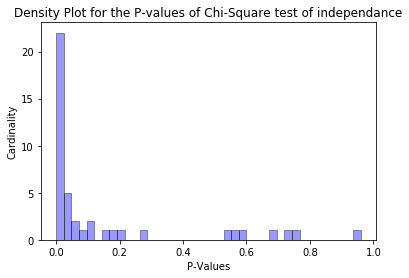

[(0, 0.9596462456603811), (1, 0.7217796435572034), (2, 2.716400964963702e-05), (3, 7.600721806796199e-06), (4, 0.6786381298660313), (5, 0.0058291267035724854), (6, 0.00037571791604203093), (7, 0.10924372104064302), (8, 0.041484719442815496), (9, 0.053565203477481185), (10, 0.002070760261597351), (11, 0.16187745077695542), (12, 0.037862496655096584), (13, 8.606024163286288e-06), (14, 0.748477469393392), (15, 0.004010030582010958), (16, 0.001369117561752162), (17, 0.04559445456134887), (18, 0.07303222778846488), (19, 0.5413490639595059), (20, 0.005064454547290014), (21, 2.6762034625140448e-05), (22, 0.2049542395621688), (23, 0.0023598008634823408), (24, 0.5551746690195145), (25, 2.0447572255420614e-05), (26, 0.043948373054996534), (27, 1.3501635146488995e-08), (28, 0.00024063574324834522), (29, 3.188071880439983e-16), (30, 0.2739450108506256), (31, 0.00026596283374260833), (32, 1.6322604411484764e-06), (33, 4.674529089351836e-05), (34, 0.006873640568380212), (35, 0.5870242751980994), (36

In [7]:
lPvalues = []
for i in range(43):
    lPvalues.append(computeChiTest(i, lResult)[1])
plt.xlabel("P-Values")
plt.ylabel("Cardinality")
plt.title("Density Plot for the P-values of Chi-Square test of independance")
sns.distplot(lPvalues, hist=True, kde=False, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.savefig("DensityPlotPvaluesTotal", dpi=900)
plt.show()
listCouplePvalueIndex = list(enumerate(lPvalues))
print(listCouplePvalueIndex)

In [8]:
listCouplePvalueIndex = sorted(listCouplePvalueIndex, key = lambda k : k[1])
print(listCouplePvalueIndex)
listDisplay = [el[0] for el in listCouplePvalueIndex]#[0:21]
listPrecised = [log(el[1])/(log(10)) for el in listCouplePvalueIndex]#[0:21]
print(listDisplay)

[(29, 3.188071880439983e-16), (27, 1.3501635146488995e-08), (32, 1.6322604411484764e-06), (3, 7.600721806796199e-06), (13, 8.606024163286288e-06), (39, 1.2352441149441277e-05), (25, 2.0447572255420614e-05), (21, 2.6762034625140448e-05), (2, 2.716400964963702e-05), (33, 4.674529089351836e-05), (40, 8.437448608852966e-05), (28, 0.00024063574324834522), (31, 0.00026596283374260833), (6, 0.00037571791604203093), (16, 0.001369117561752162), (10, 0.002070760261597351), (23, 0.0023598008634823408), (15, 0.004010030582010958), (20, 0.005064454547290014), (5, 0.0058291267035724854), (42, 0.006126853753215024), (34, 0.006873640568380212), (36, 0.028179451975130713), (12, 0.037862496655096584), (8, 0.041484719442815496), (26, 0.043948373054996534), (17, 0.04559445456134887), (37, 0.050581879739225316), (9, 0.053565203477481185), (18, 0.07303222778846488), (7, 0.10924372104064302), (41, 0.1199088276335317), (11, 0.16187745077695542), (38, 0.17471236419494038), (22, 0.2049542395621688), (30, 0.2739

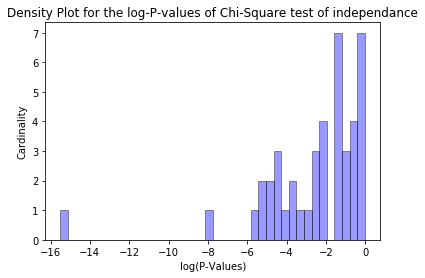

In [9]:
plt.xlabel("log(P-Values)")
plt.ylabel("Cardinality")
plt.title("Density Plot for the log-P-values of Chi-Square test of independance")
sns.distplot(listPrecised, hist=True, kde=False, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.savefig("DensityPlotPvaluesPrecised", dpi=900)
plt.show()

In [10]:
lCandidates = [29, 27, 3, 40, 32, 2, 39, 21]
for cand in lCandidates:
    print(cand)
    print(lResult[cand])

29
[(45, 0.4888888888888889), (56, 0.0), (31, 0.0), (49, 0.04081632653061224), (41, 0.04878048780487805), (24, 0.041666666666666664)]
27
[(37, 0.10810810810810811), (22, 0.0), (40, 0.425), (57, 0.07017543859649122), (80, 0.05)]
3
[(25, 0.0), (7, 0.0), (36, 0.0), (36, 0.0), (53, 0.2641509433962264), (26, 0.038461538461538464), (18, 0.05555555555555555), (21, 0.047619047619047616)]
40
[(67, 0.34328358208955223), (20, 0.15), (49, 0.04081632653061224), (27, 0.07407407407407407), (17, 0.11764705882352941), (33, 0.06060606060606061)]
32
[(67, 0.07462686567164178), (24, 0.0), (36, 0.08333333333333333), (67, 0.14925373134328357), (68, 0.36764705882352944), (48, 0.16666666666666666), (20, 0.0), (11, 0.0)]
2
[(50, 0.06), (49, 0.30612244897959184), (14, 0.07142857142857142), (37, 0.02702702702702703), (16, 0.0), (40, 0.3), (66, 0.09090909090909091)]
39
[(40, 0.25), (64, 0.125), (34, 0.029411764705882353), (42, 0.42857142857142855), (56, 0.08928571428571429), (34, 0.08823529411764706), (16, 0.125)

### Study of the distribution of the leaders among those clusters

In [11]:
def study(lCluster, lHouse, ldUse):
    lPropAdoption = []
    lPropOfLeaders = []
    for index, cluster in enumerate(lCluster):
        numberOfLeaders = 0
        for i in ldUse[index]:
            if lHouse[i,-2] == 1: #and lHouse[i, -1] == 1:
                
                numberOfLeaders += 1
        lPropOfLeaders.append(numberOfLeaders/(cluster[0]))
        print(numberOfLeaders/(cluster[0]))
        print(index)
        lPropAdoption.append(cluster[1])
    return([lPropOfLeaders, lPropAdoption])

In [12]:

lCandidates = [29, 27, 3, 40, 32, 2, 39, 21]
#lCandidates = [29, 40, 3]#, 40, 32, 2, 39, 21]
lCandidates = [29, 27, 3, 40]
lCandidates = [3]
listPropLeaders = []
listPropAdoption = []
for indexCandidates in lCandidates:
    [lPropOfLeaders, lPropAdoption] = study(lResult[indexCandidates], lHouseVill[indexCandidates], ldUse[indexCandidates])
    #lIndexToDiscard = []
    #for index in range(len(lPropOfLeaders)):
    #    if lPropAdoption[index] == 0:
    #        lIndexToDiscard = [index] + lIndexToDiscard
    #for index in lIndexToDiscard:
    #    del lPropOfLeaders[index]
    #    del lPropAdoption[index]
    listPropLeaders += (lPropOfLeaders)
    listPropAdoption += (lPropAdoption)
print(listPropAdoption)
print(listPropLeaders)
print(ldUse[29])

0.2
0
0.0
1
0.08333333333333333
2
0.08333333333333333
3
0.05660377358490566
4
0.038461538461538464
5
0.0
6
0.047619047619047616
7
[0.0, 0.0, 0.0, 0.0, 0.2641509433962264, 0.038461538461538464, 0.05555555555555555, 0.047619047619047616]
[0.2, 0.0, 0.08333333333333333, 0.08333333333333333, 0.05660377358490566, 0.038461538461538464, 0.0, 0.047619047619047616]
{0: [0, 1, 2, 3, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 57, 256], 1: [4], 2: [5, 16, 37, 47, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 84, 85, 87, 142, 163, 170, 171, 172, 173, 175, 176, 182, 184, 185, 188, 195, 240, 243, 244, 246, 248, 249, 251, 252, 254, 255], 3: [7], 4: [10], 5: [59, 88, 89, 90, 91, 92, 93, 94, 95, 96, 137, 138, 140, 148, 150, 154, 162, 197, 214, 231, 232, 234, 235, 236, 237, 238, 239, 241, 245, 250, 253], 6: [78], 7: [79], 8: [80], 9: [81, 

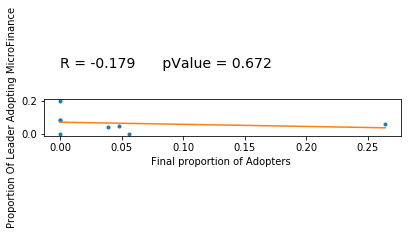

In [13]:
plt.ylabel("Proportion Of Leader Adopting MicroFinance")
plt.xlabel("Final proportion of Adopters ")
gradient, intercept, r_value, p_value, std_err = linregress(listPropAdoption,listPropLeaders)

mn=min(listPropAdoption)
mx=max(listPropAdoption)
plt.text(mn,0.4,"R = " + "{:.3f}".format(r_value) + "      pValue = " + "{:.3f}".format(p_value), size= 14)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
#sns.regplot(listPropAdoption, listPropLeaders)
plt.plot(listPropAdoption,listPropLeaders, '.')
plt.plot(x1,y1)
plt.tight_layout()
plt.savefig("RegressionPropLeaders", dpi=900)

In [14]:
for i in range(len(listPropAdoption)):
    if listPropAdoption[i] < 0.2 and listPropLeaders[i] > 0.075:
        print(i)
        print(listPropLeaders[i])

0
0.2
2
0.08333333333333333
3
0.08333333333333333


In [15]:
print(ldUse[29][2])

[5, 16, 37, 47, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 84, 85, 87, 142, 163, 170, 171, 172, 173, 175, 176, 182, 184, 185, 188, 195, 240, 243, 244, 246, 248, 249, 251, 252, 254, 255]


In [16]:
lHouseVill[29][ldUse[29][2], :]

array([[30, 6, 'HINDUISM', 'SCHEDULE CASTE', 0, 1, 0, 0, 0, 1, 0,
        'Yes, Government', 'None', 'OWNED', 0, 0],
       [30, 17, 'HINDUISM', 'SCHEDULE CASTE', 0, 1, 0, 0, 0, 2, 0,
        'Yes, Government', 'None', 'OWNED', 0, 0],
       [30, 38, 'HINDUISM', 'SCHEDULE CASTE', 0, 1, 0, 0, 0, 3, 0,
        'Yes, Government', 'None', 'OWNED', 0, 0],
       [30, 48, 'HINDUISM', 'OBC', 0, 1, 0, 0, 0, 2, 0,
        'Yes, Government', 'None', 'OWNED', 1, 0],
       [30, 51, 'HINDUISM', 'OBC', 0, 1, 0, 0, 0, 2, 0,
        'Yes, Government', 'None', 'OWNED', 0, 0],
       [30, 52, 'HINDUISM', 'OBC', 0, 1, 0, 0, 0, 2, 0,
        'Yes, Government', 'Owned', 'OWNED', 1, 0],
       [30, 53, 'HINDUISM', 'OBC', 0, 1, 0, 0, 0, 1, 0,
        'Yes, Government', 'None', 'OWNED', 1, 0],
       [30, 54, 'HINDUISM', 'OBC', 0, 1, 0, 0, 0, 2, 0,
        'Yes, Government', 'None', 'OWNED', 0, 0],
       [30, 55, 'HINDUISM', 'OBC', 0, 1, 0, 0, 0, 2, 2, 'Yes, Private',
        'None', 'OWNED', 0, 0],
       

In [17]:
print(ldUse[29])

{0: [0, 1, 2, 3, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 57, 256], 1: [4], 2: [5, 16, 37, 47, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 84, 85, 87, 142, 163, 170, 171, 172, 173, 175, 176, 182, 184, 185, 188, 195, 240, 243, 244, 246, 248, 249, 251, 252, 254, 255], 3: [7], 4: [10], 5: [59, 88, 89, 90, 91, 92, 93, 94, 95, 96, 137, 138, 140, 148, 150, 154, 162, 197, 214, 231, 232, 234, 235, 236, 237, 238, 239, 241, 245, 250, 253], 6: [78], 7: [79], 8: [80], 9: [81, 82, 83, 143, 146, 147, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 233], 10: [86], 11: [97, 98, 99, 115, 116, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 139, 141

### Is there a Correlation between Cluster of People and Proportion of adoption? yes7

### Community Robustness via Scale Persistence

In [18]:
## Community detection by changing parameter gamma and see if there is a "Stagnation on certain communities" with high proportion of adopters

### Community robustness via Entropy

We compare the clustering between the set of adopters/non-adopters with the clustering given by the Louvain algorithm. This measure behave as a metric on the set of clustering and gives a measure of how one cluster gives information about the other. Thus, for each village we can compute this distance and see which village has the smallerst distance.

In [19]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return(lst3)

def variationInfo(dCluster1, dCluster2):
    lP1 = []
    n1 = 0
    for c1 in dCluster1:
        n1 += len(dCluster1[c1])
        lP1.append(len(dCluster1[c1]))
    lP1 = [el/n1 for el in lP1]
    lP2 = []
    n2 = 0
    for c2 in dCluster2:
        n2 += len(dCluster2[c2])
        lP2.append(len(dCluster2[c2]))
    print(n1 == n2)
    lP2 = [el/n2 for el in lP2]
    lP1P2 = [[len(intersection(dCluster1[el1], dCluster2[el2]))/n1 for el2 in dCluster2] for el1 in dCluster1]
    mutualI = 0
    for el1 in dCluster1:
        for el2 in dCluster2:
            if lP1P2[el1][el2] != 0:
                mutualI += lP1P2[el1][el2]*log((lP1P2[el1][el2])/(lP1[el1]*lP2[el2]))
    
    H1, H2 = 0, 0
    for el1 in dCluster1:
        H1 -= lP1[el1]*log(lP1[el1])
    for el2 in dCluster2:
        H2 -= lP2[el2]*log(lP2[el2])
    return(H1 + H2 - 2*mutualI)
    

#### Comparison for each village

In [20]:
lScoreInformation = []
for i in range(43):
    dCluster1 = ldUse[i]
    lHouse = lHouseVill[i]
    dCluster2 = {}
    dCluster2[0] = []
    dCluster2[1] = []
    for node in range(lHouse.shape[0]):
        if lHouse[node][-1] == 1:
            dCluster2[0].append(node)
        else:
            dCluster2[1].append(node)
    lScoreInformation.append((i,variationInfo(dCluster1, dCluster2)))
lScoreInformation = sorted(lScoreInformation, key = lambda k : k[1])
print(lScoreInformation)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
[(5, 2.0074719531743397), (29, 2.0178650746005684), (27, 2.021885481792349), (13, 2.0357173665848536), (1, 2.040438972963805), (41, 2.072328198062761), (37, 2.086574716911474), (36, 2.1208846915459105), (33, 2.1702467987635896), (40, 2.1847200828190827), (7, 2.1858991053434886), (42, 2.222836193647604), (21, 2.225449170868351), (25, 2.226467194704463), (12, 2.228169005464707), (28, 2.237339062131246), (8, 2.262337796275567), (35, 2.264764298881871), (24, 2.2911893940779886), (23, 2.319869892126036), (15, 2.337685872479182), (16, 2.3424271620461297), (18, 2.352362489788098), (26, 2.3588482380025546), (39, 2.3662635824618294), (31, 2.370470786427294), (3, 2.3840848122217255), (38, 2.418568944784627), (32, 2.418785927559213), (2, 2.424547841134872), (4, 2.4394426587759828), (20

[5, 29, 27, 13, 1, 41, 37, 36, 33, 40, 7, 42, 21, 25, 12, 28, 8, 35, 24, 23, 15, 16, 18, 26, 39, 31, 3, 38, 32, 2, 4, 20, 34, 30, 17, 6, 0, 11, 22, 10, 19, 14, 9]
Fit results: mu = 2.34,  std = 0.22


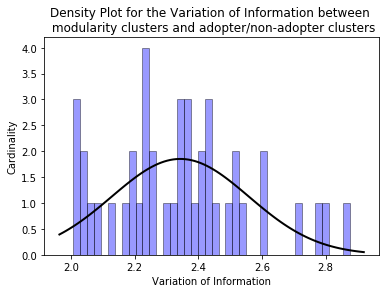

In [21]:

listVI = [el[1] for el in lScoreInformation]#[0:21]
listDisplay = [el[0] for el in lScoreInformation]
print(listDisplay)
plt.xlabel("Variation of Information")
plt.ylabel("Cardinality")
plt.title("Density Plot for the Variation of Information between \n modularity clusters and adopter/non-adopter clusters")
sns.distplot(listVI, hist=True, kde=False, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'})



mu, std = norm.fit(listVI)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
print("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.savefig("DensityPlotVI", dpi=900)
plt.show()

In [22]:
41 

41

In [23]:
lCandidates2 = [40,29,36,5,42,28, 33, 1, 18, 8]
for cand in lCandidates2:
    print(cand)
    print(lResult[cand])

40
[(67, 0.34328358208955223), (20, 0.15), (49, 0.04081632653061224), (27, 0.07407407407407407), (17, 0.11764705882352941), (33, 0.06060606060606061)]
29
[(45, 0.4888888888888889), (56, 0.0), (31, 0.0), (49, 0.04081632653061224), (41, 0.04878048780487805), (24, 0.041666666666666664)]
36
[(44, 0.13636363636363635), (28, 0.35714285714285715), (39, 0.28205128205128205), (62, 0.41935483870967744), (18, 0.2222222222222222)]
5
[(23, 0.08695652173913043), (53, 0.32075471698113206), (41, 0.14634146341463414), (14, 0.35714285714285715), (70, 0.1)]
42
[(38, 0.18421052631578946), (29, 0.1724137931034483), (43, 0.2558139534883721), (25, 0.08), (29, 0.4827586206896552)]
28
[(75, 0.08), (71, 0.014084507042253521), (27, 0.3333333333333333), (42, 0.09523809523809523), (17, 0.0), (43, 0.13953488372093023), (41, 0.14634146341463414)]
33
[(21, 0.3333333333333333), (43, 0.13953488372093023), (36, 0.05555555555555555), (16, 0.0), (47, 0.3829787234042553), (13, 0.0), (10, 0.0)]
1
[(56, 0.125), (19, 0.157894

[-0.04119055653466065, -0.32603538950253114, -10.51361763547656, -11.787267340603341, -0.3876672391948843, -5.144888083395231, -7.886671919425175, -2.2141739199702837, -3.182430125747248, -2.926855610572671, -6.179839463000243, -1.8209157067080828, -3.273794190972223, -11.663048115826234, -0.28971417658633086, -5.5189564112560925, -6.59358886218299, -3.087969180353688, -2.6168544587015345, -0.613690988312333, -5.285508837645192, -10.528526293264944, -1.5849685464093461, -6.049178043385165, -0.5884724957952441, -10.797646398639131, -3.1247396736249535, -18.120455036874553, -8.332226206653035, -35.68194518004149, -1.294827883061249, -8.23215398171686, -13.32554473011748, -9.970797036853549, -4.980061390490078, -0.5326891053275216, -3.5691622199991175, -2.984161874745119, -1.744614290477329, -11.301656850500857, -9.380245499592741, -2.12102359469195, -5.095073914755578]


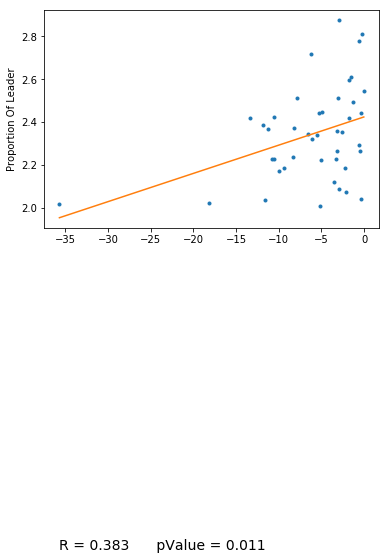

In [24]:
listCouplePvalueIndexOri = sorted(listCouplePvalueIndex, key = lambda k : k[0])
listPvalueOri = [log(el[1]) for el in listCouplePvalueIndexOri]
print(listPvalueOri)
lScoreInformationOri = sorted(lScoreInformation, key = lambda k : k[0])
lScoreInformationOri = [el[1] for el in lScoreInformationOri]
plt.ylabel("Proportion Of Leader")
gradient, intercept, r_value, p_value, std_err = linregress(listPvalueOri,lScoreInformationOri)

mn=min(listPvalueOri)
mx=max(listPvalueOri)
plt.text(mn,0.4,"R = " + "{:.3f}".format(r_value) + "      pValue = " + "{:.3f}".format(p_value), size= 14)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(listPvalueOri,lScoreInformationOri, '.')
plt.plot(x1,y1)

### Community robustness via comparison with configuration model

In [25]:
lCandidates = [29,27, 3, 40, 32, 2, 39, 16, 21]
for index in lCandidates:
    Gplop = nx.from_numpy_matrix(lData[index])
    n = Gplop.number_of_nodes()
    z = [Gplop.degree[i] for i in range(n)]
    Gconf = nx.configuration_model(z)
    Gconf=nx.Graph(Gconf)
    Gconf.remove_edges_from(Gconf.selfloop_edges())
    Aconf = nx.adjacency_matrix(Gconf)
    dictCom = community.best_partition(Gconf)
    [lFraction, maxEl, dUse] = partitionAnal(dictCom, lHouseVill[index])
    resultConf = lFraction
    table = createContingencyTable(resultConf)
    res = chi2_contingency(table)
    print(res[1])

0.37662522017107297
0.6933901172580751
0.4834866032395535
0.9745384553557424
0.17316554494868647
0.04467044058710291
0.4742964893745307
0.31270072905004187
0.7943710025779334


In [26]:
dictCom = community.best_partition(Gconf)
[lFraction, maxEl, dUse] = partitionAnal(dictCom, lHouseVill[29])
resultConf = lFraction
table = createContingencyTable(resultConf)
res = chi2_contingency(table)

print(res[1])

0.8588967938893339


In [27]:
tree = nx.minimum_spanning_tree(nx.from_numpy_matrix(lData[29]))
print(tree)
print(nx.is_tree(tree))
color_map = []
for i in range(lData[29].shape[0]):
    if lHouseVill[29][i,-1] == 1:
        color_map.append('blue')
    else:
        color_map.append('red')
pos = nx.graphviz_layout(tree,k=1,iterations=50)
nx.draw(tree,pos, node_color = color_map,with_labels = False)
print(color_map)


False


AttributeError: module 'networkx' has no attribute 'graphviz_layout'

In [ ]:
nTest = 0
for i in range(43):
    nTest += lData[i].shape[0]
print(nTest)

In [76]:
Ad = lData[29]
print(Ad.shape[0])
Gd = nx.from_numpy_matrix(Ad)
Tree = nx.algorithms.tree.mst.maximum_spanning_tree(Gd)
Atree = scipy.sparse.csr_matrix.toarray(nx.adjacency_matrix(Tree))
print(type(Atree))
pos = nx.graphviz_layout(Gd,k=1,iterations=50)
nx.draw(Gd,pos, node_color = color_map,with_labels = False)

257
<class 'numpy.ndarray'>


AttributeError: module 'networkx' has no attribute 'graphviz_layout'

In [77]:
g = igraph.Graph.Weighted_Adjacency(Ad.tolist())

g.vs["label"] = [i for i in range(257)]
print(g.is_connected())
inv_weight = [-1./w for w in g.es["weight"]]
nice = g.spanning_tree(weights=inv_weight)
nice = igraph.Graph.Adjacency(Atree.tolist() , mode = ADJ_UNDIRECTED)
print(nice.is_connected())
print(g.vcount())

False
False
257


In [78]:
lColors = [0 for i in range(lData[29].shape[0])]
print(len(ldUse[29]))
pal = igraph.drawing.colors.ClusterColoringPalette(len(ldUse))
for i in ldUse[29]:
    for index in ldUse[29][i]:
        lColors[index] = pal.get(i)
nice.vs['color'] = lColors

nice.vs["label"] = [lHouseVill[29][i,-1] for i in range(lData[29].shape[0])]

17


In [79]:
pal.get_many([0,1,2, 2])

[(1.0, 0.0, 0.0, 1.0),
 (0.0, 1.0, 0.0, 1.0),
 (0.0, 0.0, 1.0, 1.0),
 (0.0, 0.0, 1.0, 1.0)]

In [91]:
igraph.plot(nice,"graph29.pdf")
#plt.savefig("graph29", dpi = 900)
plt.show()

In [67]:
np.sum(Ad)

1784

In [ ]:
igraph.plot(g)